In [8]:
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk

# nltk 다운로드 (불용어, punkt)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
import pandas as pd
import numpy as np

spam = pd.read_csv('/content/drive/MyDrive/Tobigs/week_7 Vision basic, NLP basic /NLP basic/과제/spam.csv', encoding='latin-1')

In [3]:
spam.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
spam.isnull().sum()

v1    0
v2    0
dtype: int64

In [7]:
spam.describe().T

,count,unique,top,freq
v1,5572,2,ham,4825
v2,5572,5169,"Sorry, I'll call later",30


In [15]:
# 텍스트 전처리 함수
def preprocess_text(text):
    # 소문자 변환
    text = text.lower()

    # 특수 문자 제거
    text = re.sub(r'\W', ' ', text)

    # 공백 여러 개 하나로 줄이기
    text = re.sub(r'\s+', ' ', text).strip()

    # 불용어 제거
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_text = [word for word in words if word not in stop_words]

    # Stemming을 적용하여 단어를 그 기본 형태로 변환. 같은 의미의 단어가 다른 형태로 사용된 경우를 통일함
    ps = PorterStemmer()
    stemmed_text = [ps.stem(word) for word in filtered_text]
    return ' '.join(stemmed_text)

# 텍스트 전처리
spam['v2'] = spam['v2'].apply(preprocess_text)

In [16]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

#텍스트 데이터를 문장별로 토큰화
sentences = [word_tokenize(text) for text in spam['v2']]

# Word2Vec 모델을 초기화하고 학습
# size: 임베딩 벡터의 차원
# window: 컨텍스트 윈도우 크기
# min_count: 모델 학습에 사용할 단어의 최소 빈도수
# workers: 학습을 위한 쓰레드 수
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


print(word2vec_model)

Word2Vec<vocab=7245, vector_size=100, alpha=0.025>


- 코사인 유사도는 벡터의 크기가 아니라 방향성을 기반으로 유사도를 측정한다. 이는 텍스트의 길이나 빈도수가 다르더라도, 유사한 주제나 의미를 가진 문서를 비교할 때 유용하다. 따라서, 텍스트 데이터를 벡터로 변환하면 차원이 매우 높아질 수 있는데, 코사인 유사도는 이러한 고차원 공간에서도 두 벡터 간의 유사도를 효과적으로 측정할 수 있다.

유사도: 0.0


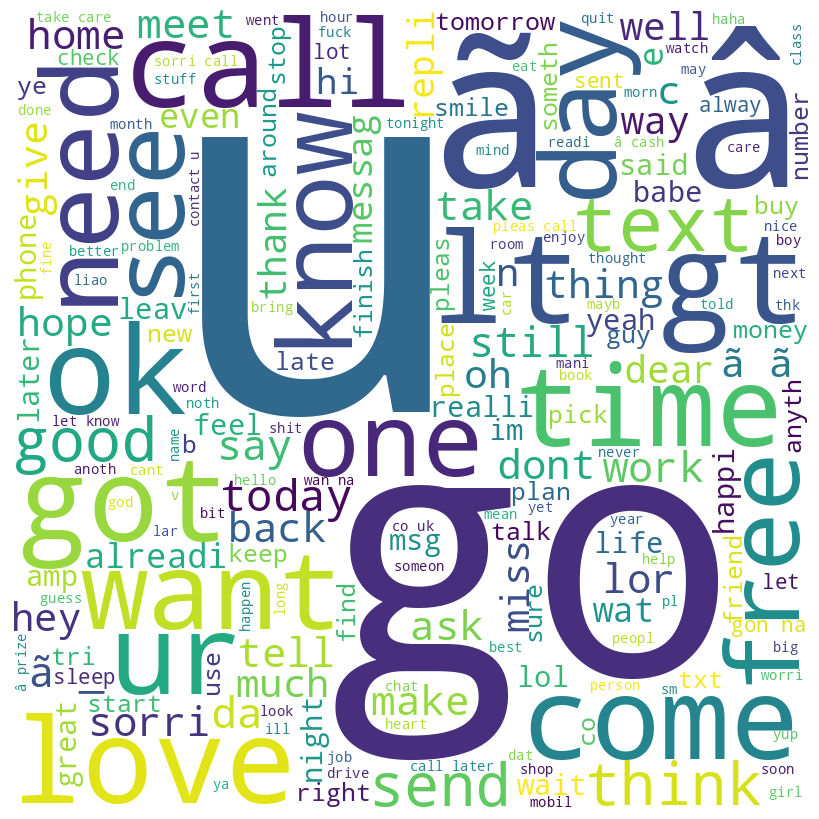

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.92      0.92      0.92       150

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# 유사도 계산 예시 (첫 번째 문서와 두 번째 문서 비교)
similarity = cosine_similarity(X[0].reshape(1, -1), X[1].reshape(1, -1))
print(f'유사도: {similarity[0][0]}')

# Wordcloud 생성
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(spam['v2']))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# 이진 분류 모델 학습 및 평가
y = spam['v1'].map({'ham': 0, 'spam': 1}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))